In [2]:
from __future__ import print_function
import gffutils
import operator
import matplotlib.pyplot as plt
import math 
import numpy as np
import pandas as pd

np.random.seed(444)
from collections import namedtuple

In [3]:
class Node:
    def __init__(self, id, start, end, seq = ""):
        self.id = id
        self.start = start
        self.end = end
        self.seq = seq
        
    def get_seq(self, start, end):
        return self.seq[start:end]

    def print_node(self):
        print(str(self.id),str(self.start),str(self.end))
        
class Edge:
    def __init__(self, id, start_node_id, end_node_id, length = 0, weight = 1):
        self.id = id
        self.start_node_id = start_node_id
        self.end_node_id = end_node_id
        self.length = length
        self.weight = weight

    def print(self):
        print(str(self.start_node_id),
                  str(self.end_node_id),str(self.length))

        
class GeneGraph:
    def __init__(self, gene_id, species, genome_assembly):
        self.gene_id = gene_id
        self.species = species
        self.genome_assembly = genome_assembly
        self.nodes = dict() # anything included in one or more transcripts
        self.edges = dict() # anything spliced out in one or more transcripts
        self.start_positions = [] # start nodes
        self.end_positions = [] # end nodes
        self.start_x = 0
        self.end_x = 1
        self.start_y = 0
        
    def build_graph_elements(self):
        """
           Builds a list of named tuples with
           with both edges and nodes to prepare
           the gene graph structure for plotting
        """
        elements = []
        self.node_starts = []
        self.node_ends = []
        edge_starts = []
        edge_ends = []
        for node in self.nodes.values():
            self.node_starts.append(node.start)
            self.node_ends.append(node.end)
            elements.append({'start': node.start, 'end': node.end, 'id': node.id,
                             'type': 'Node', 'weight': 1, 'length': (node.end - node.start),
                            'x': node.start, 'y': 1})
        for edge in self.edges.values():
            edge_starts.append(self.nodes[edge.start_node_id].end)
            edge_ends.append(self.nodes[edge.end_node_id].start)
            elements.append({'start': self.nodes[edge.start_node_id].end, 'end': self.nodes[edge.end_node_id].start, 'id': edge.id,
                             'type': 'Edge', 'weight': edge.weight, 'length': edge.length,
                            'x': self.nodes[edge.start_node_id].end, 'y': 1})
        elements.sort(key=lambda x:(x['start'],x['end']))
        self.elements = elements
        
        # build a dict of node start and edge end positions to figure out how many levels are needed for each start position
        start_positions = dict()
        for element in self.elements:
            if element['type'] == 'Node':
                start_positions[element['start']] = start_positions.get(element['start'],0) + 1
            if element['type'] == 'Edge':
                start_positions[element['end']] = start_positions.get(element['end'],0) + 1

        # build a dict of end positions to figure out how many levels are needed for each end position
        end_positions = dict()
        for element in self.elements:
            if element['type'] == 'Node':
                end_positions[element['end']] = end_positions.get(element['end'],0) + 1
            if element['type'] == 'Edge':
                start_positions[element['start']] = start_positions.get(element['start'],0) + 1
        
        # we would like to have edges as the base level and nodes shifted up if needed
        # we shift the x positions by shrinking intron sizes
        has_previous_node = False
        previous_node = self.elements[0]
        start_position = previous_node['start']
        new_elements = []
        for element in self.elements:
            if element['type'] == 'Node':
                element['y'] = start_positions[element['start']] #+ end_positions[element['end']]# this has the maximum level
                if element['end'] in self.node_starts:
                    element['y'] += 1
                start_positions[element['start']] -= 1 # we decrement
                if has_previous_node:
                    if element['start'] - previous_node['end'] > 0:
                        element['x'] = previous_node['x'] + previous_node['length'] + 10*math.log(int(element['start'])-int(previous_node['end']))
                    else:
                        element['x'] = previous_node['x'] + previous_node['length']
                else:
                    element['x'] = 0 # first node, start at 0
                previous_node = element
                has_previous_node = True
                new_elements.append(element)
        for element in self.elements:
            if element['type'] == 'Edge':
                #element['y'] = start_positions[element['end']] # this has the maximum level
                start_positions[element['end']] -= 1 # we decrement
                new_elements.append(element)
        self.elements = sorted(new_elements, key=lambda x:(x['start'],x['end']))
        #print(str(self.elements))
        
    
    def draw(self, bg_color="white", node_color="black", edge_color="grey", retained_intron_color="red"):
        self.figure, self.canvas = plt.subplots(figsize=(20,1.5))
        self.canvas.set_facecolor(bg_color)
        node_start_y = dict()
        node_end_y = dict()
        for element in self.elements: # draw nodes
            if element['type'] == 'Node':
                #print("Plotting node:",element['id'],str(element['start']),str(element['end']),str(element['x']),str(element['x']+element['length']))
                node_start_y[element['start']] = element['y']
                node_end_y[element['end']] = element['y']
                draw_node_color = node_color
                for edge in self.edges.values():
                    start = self.nodes[edge.start_node_id].end
                    end = self.nodes[edge.end_node_id].start
                    if start == element['start'] and end == element['end']: # intron_retention
                        draw_node_color = retained_intron_color
                self.canvas.fill_between([element['x'],element['x']+element['length']], element['y']-0.25, element['y']+0.25,
                                 edgecolor=bg_color, facecolor=draw_node_color)
        for element in self.elements: # draw nodes
            if element['type'] == 'Edge':
                #print("Plotting edge:",element['id'],str(element['start']),str(element['end']))
                edge = self.edges[element['id']]
                # find the upstream node element - rework as it's not optimal...
                for element2 in self.elements:
                    if element2['type'] == "Node":
                        if element2['id'] == edge.start_node_id:
                            element['x1'] = element2['x'] + element2['length']
                        if element2['id'] == edge.end_node_id:
                            element['x2'] = element2['x']
                if element['id'] == 9999999:
                    self.canvas.plot([element['x1'],element['x2']], [node_end_y[element['start']], node_start_y[element['end']]],
                         c="red", lw=element['weight'], ls='-')
                else:
                    self.canvas.plot([element['x1'],element['x2']], [node_end_y[element['start']], node_start_y[element['end']]],
                         c=edge_color, lw=element['weight'], ls='-')

        self.canvas.set_yticks([], minor = [])
        self.canvas.get_xaxis().tick_top()
        self.canvas.tick_params(axis='x', direction='out')
        self.canvas.set_xticks([])
        for o in ["top", "bottom", "left", "right"]:
            self.canvas.spines[o].set_visible(False)


        plt.show()

    def print_nodes(self):
        list_of_nodes = []
        for node in self.nodes.values():
            list_of_nodes.append(node)
        for node in sorted(list_of_nodes, key=lambda x: x.start):
            print(str(node.id),str(node.start),str(node.end))
            
    def print_edges(self):
        list_of_edges = []
        for edge in self.edges.values():
            list_of_edges.append(edge)
        for edge in sorted(list_of_edges, key=lambda x: self.nodes[x.start_node_id].start):
            #print(str(edge.start_node_id),str(edge.end_node_id),str(edge.length))
            print(str(edge.start_node_id),str(self.nodes[edge.start_node_id].end),
                  str(edge.end_node_id),str(self.nodes[edge.end_node_id].start),str(edge.length))

    def add_edge(self, start_node, end_node):
        if len(self.edges) == 0:
            id = 1
            length = abs(max(start_node.start,start_node.end) - min(end_node.start,end_node.end))
            self.edges[id] = Edge(id = id, start_node_id = start_node.id, end_node_id = end_node.id, length = length)
            return 1
        else:
            id = max(self.edges.keys()) + 1 # increment the id
        novel = True
        for edge in self.edges.values():
            if edge.start_node_id == start_node.id and edge.end_node_id == end_node.id:
                novel = False
        if novel:
            length = abs(max(start_node.start,start_node.end) - min(end_node.start,end_node.end))
            self.edges[id] = Edge(id = id, start_node_id = start_node.id, end_node_id = end_node.id, length = length)
            return 1
        return 0 # something went wrong!
    
    def add_node(self, new_node):
        for node in self.nodes.values():
            if node.start == new_node.start and node.end == new_node.end:
                return 0
        if new_node.start != new_node.end:
            self.nodes[new_node.id] = new_node
            return 1
        return 0 # something went wrong!
    
    def add_exon(self, start, end, seq="", debug=False):
        if len(self.nodes) == 0:
            id = 1
            self.nodes[id] = Node(id = id, start = start, end = end, seq = seq)
            return 1
        else:
            id = max(self.nodes.keys()) + 1 # increment the id
            
            # get all the existing nodes that somehow overlap the new
            overlapping_nodes = []
            if debug:
                print("Searching for overlapping nodes")
            for node in self.nodes.values():
                if start == node.start and end == node.end:
                    if debug:
                        print(" - Identical node already exists")
                    return 1 # identical to previous node, abort the rest
                if start >= node.start and start <= node.end: 
                    overlapping_nodes.append(node)
                elif end >= node.start and end <= node.end:
                    overlapping_nodes.append(node)
                elif start < node.start and end > node.end: # node spans
                    overlapping_nodes.append(node)
                else:
                    if debug:
                        print(" - node did not overlap:",str(node.id),str(node.start),str(node.end))
            
            # if no overlap, just add the node
            if len(overlapping_nodes) == 0:
                return self.add_node(Node(id = id, start = start, end = end, seq = ""))
            
            # now build the new nodes
            for node in sorted(overlapping_nodes, key=lambda x: x.start):
                if debug:
                    print(str(node.id),str(node.start),str(node.end))
                del self.nodes[node.id]
                # since the list is sorted, we know we can build the node as we go along
                if node.start < start and node.end <= end: # build 2 new nodes and leave the rest
                    id += self.add_node(Node(id = id, start = node.start, end = start, seq = ""))
                    id += self.add_node(Node(id = id, start = start, end = node.end, seq = ""))
                    start = node.end
                elif node.start < start and node.end > end: # old node spans fully, make 3 new nodes
                    id += self.add_node(Node(id = id, start = node.start, end = start, seq = ""))
                    id += self.add_node(Node(id = id, start = start, end = end, seq = ""))
                    return self.add_node(Node(id = id, start = end, end = node.end, seq = ""))
                elif node.start == start and node.end <= end: 
                    id += self.add_node(Node(id = id, start = start, end = node.end, seq = ""))
                    start = node.end
                elif node.start == start and node.end > end:
                    id += self.add_node(Node(id = id, start = start, end = end, seq = ""))
                    return self.add_node(Node(id = id, start = end, end = node.end, seq = ""))
                elif node.start > start and node.end <= end: #node within the new node
                    id += self.add_node(Node(id = id, start = start, end = node.start, seq = ""))
                    id += self.add_node(Node(id = id, start = node.start, end = node.end, seq = ""))
                    start = node.end
                elif node.start > start and node.end > end:
                    id += self.add_node(Node(id = id, start = start, end = node.start, seq = ""))
                    id += self.add_node(Node(id = id, start = node.start, end = end, seq = ""))
                    return self.add_node(Node(id = id, start = end, end = node.end, seq = ""))
            if start < end: # make the last trailing bit 
                return self.add_node(Node(id = id, start = start, end = end, seq = ""))
            elif start == end: # we parsed the whole exon
                return 1

        return 0 # something happened and we didn't add the node!
    
    def add_intron(self, start, end):
        start_node = False
        end_node = False
        for node in sorted([x for x in self.nodes.values()], key=lambda x: x.start):
            if node.end == start:
                start_node = node
            if node.start == end:
                end_node = node
            if start_node and end_node:
                self.add_edge(start_node, end_node)
                return 1
        return 0
            
    def add_zero_length_edges(self):
        sorted_nodes = sorted([x for x in self.nodes.values()], key=lambda x: x.start)
        for i in range(len(self.nodes)):
            if i == 0:
                previous_node = sorted_nodes[i]
            else:
                current_node = sorted_nodes[i]
                if current_node.start == previous_node.end:
                    self.add_edge(start_node = previous_node, end_node = current_node)
                previous_node = current_node

In [5]:
# m_gtf = "mm10.Ens101.Atp5c1.gtf"
# h_gtf = "gencode.v39.ATP5F1C.gtf"
m_gtf = "Mus_musculus.GRCm39.106.chr.gtf"
ch_gtf = "Pan_troglodytes.Pan_tro_3.0.106.chr.gtf"

mdb = gffutils.create_db(m_gtf, dbfn='mtest.db', force=True, keep_order=True,
                        disable_infer_genes=True, disable_infer_transcripts=True,
                        merge_strategy='merge', sort_attribute_values=True)

chdb = gffutils.create_db(ch_gtf, dbfn='chtest.db', force=True, keep_order=True,
                        disable_infer_genes=True, disable_infer_transcripts=True,
                        merge_strategy='merge', sort_attribute_values=True)

#test gene mouse
mgene = mdb['ENSMUSG00000026024']
#test gene shimpanzee
chgene = chdb['ENSPTRG00000012811']

In [ ]:
# gene = db['ENSMUSG00000025781']
# gene_graph = GeneGraph(gene.attributes['gene_id'], "mouse","hg38")
# human
chgene = chdb['ENSPTRG00000012811']
chgene_graph = GeneGraph(hgene.attributes['gene_id'], "chimpanze","Pan_tro")


debug = False
# loop through the transcripts of the gene and build the nodes
for tx in chdb.children(chgene, featuretype='transcript', order_by='start'):
    exon_count = 0
    for exon in chdb.children(tx, featuretype='exon', order_by='start'):
        exon_count += 1
        if exon_count == 1:
            chgene_graph.start_positions.append(int(exon.start)-1)
        if chgene_graph.add_exon(start = int(exon.start) - 1, end = int(exon.end), debug = debug) == 0:
            print("Error adding exon:",str(int(exon.start - 1)),str(int(exon.end)))
    hgene_graph.end_positions.append(int(exon.end))

# automatically add zero-length edges to all the juxtaposed nodes
chgene_graph.add_zero_length_edges()

# loop through the transcripts of the gene and build the edges
for tx in chdb.children(chgene, featuretype='transcript', order_by='start'):
    previous = 0
    for exon in chdb.children(tx, featuretype='exon', order_by='start'):
        if previous == 0:
            previous = exon
        else:
            current = exon
            
            if chgene_graph.add_intron(start = previous.end, end = current.start - 1) == 0:
                print("Error adding intron:",str(previous.end),str(current.start-1))
            previous = current

In [ ]:
# mouse
mgene = mdb['ENSMUSG00000026024']
mgene_graph = GeneGraph(mgene.attributes['gene_id'], "mouse","hg38")

debug = False
# loop through the transcripts of the gene and build the nodes
for tx in mdb.children(mgene, featuretype='transcript', order_by='start'):
    exon_count = 0
    for exon in mdb.children(tx, featuretype='exon', order_by='start'):
        exon_count += 1
        if exon_count == 1:
            mgene_graph.start_positions.append(int(exon.start)-1)
        if mgene_graph.add_exon(start = int(exon.start) - 1, end = int(exon.end), debug = debug) == 0:
            print("Error adding exon:",str(int(exon.start - 1)),str(int(exon.end)))
    mgene_graph.end_positions.append(int(exon.end))

# automatically add zero-length edges to all the juxtaposed nodes
mgene_graph.add_zero_length_edges()

# loop through the transcripts of the gene and build the edges
for tx in mdb.children(mgene, featuretype='transcript', order_by='start'):
    previous = 0
    for exon in mdb.children(tx, featuretype='exon', order_by='start'):
        if previous == 0:
            previous = exon
        else:
            current = exon
            if mgene_graph.add_intron(start = previous.end, end = current.start - 1) == 0:
                print("Error adding intron:",str(previous.end),str(current.start-1))
            previous = current

In [ ]:
##mouse
mgene_graph.build_graph_elements()
mgene_graph.draw(bg_color="white", node_color="grey", edge_color="black", retained_intron_color="red")

In [ ]:
##chimpanzea
chgene_graph.build_graph_elements()
chgene_graph.draw(bg_color="white", node_color="grey", edge_color="black", retained_intron_color="red")

In [ ]:
# canvas

figure, canvas = plt.subplots(figsize=(20,5))
canvas.set_facecolor('white') # background color # ---USER INPUT--- #
canvas.set_title('Single gene splicing graph of a Mouse gene=ENSMUSG00000026024', size=25)

node_start_y = {}
node_end_y = {}
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

levels = []

for element in mgene_graph.elements:
    # append level number to an array
    levels.append(element['y']) if element['y'] not in levels else levels
    
    if element['type'] == 'Node':
        node_start_y[element['start']] = element['y'] # ???
        node_end_y[element['end']] = element['y'] # ???
        
        # Node colloring
        if element['start'] in mgene_graph.start_positions:
            draw_node_color = 'dodgerblue'
        elif element['end'] in mgene_graph.end_positions:
            draw_node_color = 'red'
        elif element['start'] in mgene_graph.start_positions and element['end'] in mgene_graph.end_positions:
            draw_node_color = 'violet'
        else:
            draw_node_color = 'grey'
        
        for edge in mgene_graph.edges.values():
            start = mgene_graph.nodes[edge.start_node_id].end
            end = mgene_graph.nodes[edge.end_node_id].start
            if start == element['start'] and end == element['end']:
                retained_intron_color = 'orange'
#         print(element['start'], element['x'])
        canvas.fill_between([element['x'], element['x']+element['length']], element['y']-0.15, element['y']+0.15, edgecolor='black', facecolor=draw_node_color)
levels.sort()

for element in mgene_graph.elements:
    if element['type'] == 'Edge':
        edge = mgene_graph.edges[element['id']]
        for element2 in mgene_graph.elements:
            if element2['type'] == "Node":
                if element2['id'] == edge.start_node_id:
                    element['x1'] = element2['x'] + element2['length']
                if element2['id'] == edge.end_node_id:
                    element['x2'] = element2['x']
        if element['id'] == 9999999: # ???
            canvas.plot([element['x1'], element['x2']], [node_end_y[element['start']], node_start_y[element['end']]], color='yellow', linewidth=element['weight'], ls='-', )
        else:
            canvas.plot([element['x1'],element['x2']], [node_end_y[element['start']], node_start_y[element['end']]], color='black', linewidth=element['weight'], ls='-', ) 

In [ ]:
figure, canvas = plt.subplots(figsize=(20,5))
canvas.set_facecolor('white') # background color # ---USER INPUT--- #
canvas.set_title('Single gene splicing graph of a Mouse gene=ENSMUSG00000026024', size=25)

plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
node_start_y = {}
node_end_y = {}

levels = []

for element in chgene_graph.elements:
    # append level number to an array
    levels.append(element['y']) if element['y'] not in levels else levels
    
    if element['type'] == 'Node':
#         print(element)
        node_start_y[element['start']] = element['y'] # ???
        node_end_y[element['end']] = element['y'] # ???
        
        # Node colloring
        if element['start'] in chgene_graph.start_positions:
            draw_node_color = 'dodgerblue'
        elif element['end'] in chgene_graph.end_positions:
            print(element['end'])
            draw_node_color = 'red'
        elif element['start'] in chgene_graph.start_positions and element['end'] in chgene_graph.end_positions:
            draw_node_color = 'violet'
        else:
            draw_node_color = 'grey'
        
        for edge in chgene_graph.edges.values():
            start = chgene_graph.nodes[edge.start_node_id].end
            end = chgene_graph.nodes[edge.end_node_id].start
            if start == element['start'] and end == element['end']:
                retained_intron_color = 'orange'
        canvas.fill_between([element['x'], element['x']+element['length']], element['y']-0.15, element['y']+0.15, edgecolor='black', facecolor=draw_node_color)
levels.sort()
for element in chgene_graph.elements:
    if element['type'] == 'Edge':
        edge = chgene_graph.edges[element['id']]
        for element2 in chgene_graph.elements:
            if element2['type'] == "Node":
                if element2['id'] == edge.start_node_id:
                    element['x1'] = element2['x'] + element2['length']
                if element2['id'] == edge.end_node_id:
                    element['x2'] = element2['x']
        if element['id'] == 9999999: # ???
            canvas.plot([element['x1'], element['x2']], [node_end_y[element['start']], node_start_y[element['end']]], color='yellow', linewidth=element['weight'], ls='-', )
        else:
            canvas.plot([element['x1'],element['x2']], [node_end_y[element['start']], node_start_y[element['end']]], color='black', linewidth=element['weight'], ls='-', ) 

SEQ ALIGNMENT

In [ ]:
from Bio.SeqRecord import SeqRecord
from Bio.pairwise2 import format_alignment
from Bio import pairwise2
from Bio import SeqIO
from Bio import AlignIO 

def read_fasta_file(genome):
    
    all_genome_sequences = []

    with open(genome) as handle:
        for record in SeqIO.parse(handle, "fasta"):
            all_genome_sequences.append(record.seq)
    
    return all_genome_sequences

## Get the sequence
## CHIMPANZEE
chgenome_filename = 'Pan_troglodytes.Pan_tro_3.0.dna.chromosome.2B.fa' # human
chall_genome_seq = read_fasta_file(chgenome_filename)

## MOUSE
mgenome_filename = 'Mus_musculus.GRCm39.dna.chromosome.1.fa' # mouse
mall_genome_seq = read_fasta_file(mgenome_filename)

## Mouse seq
mouse_seq = {}

for node in mgene_graph.elements:
    for key, val in node.items():
        if val == "Node":
            seq_test = mall_genome_seq[0][node['start']:node['end']]
            mouse_seq[node['id']]=seq_test 
            
## Chimpanzee seq
ch_seq = {}

for node in chgene_graph.elements:
    for key, val in node.items():
        if val == "Node":
            seq_test = chall_genome_seq[0][node['start']:node['end']]
            ch_seq[node['id']]=seq_test        
            
#Normalization = score from pair-wise alignment / max length of both sequences
normalized_scores = []

for k1,v1 in ch_seq.items():
    for k2,v2 in mouse_seq.items():
        if v1 == '' or v2 == '':
            normalized_score_test = 0.0
            normalized_scores.append(normalized_score_test)
        else: 
            max_seq_length = max(len(v1), len(v2))
            local_alignment_score = pairwise2.align.localms(str(v1), str(v2), 3, 0, -1, 0, score_only=True)
            normalized_score = local_alignment_score/max_seq_length
            normalized_score = normalized_score/3
            normalized_scores.append(normalized_score)

# just added sorting in asc order
normalized_scores.sort()

# Creating a histogram by hand

def count_elements(seq) -> dict:
    hist = {}
    for i in seq:
        hist[i] = hist.get(i, 0) + 1
    return hist

normalized_scores_hist= count_elements(normalized_scores) 

# The alignment score dataframe
normalized_scores_test = []
data = []
x = []
y = []

for key1, node1 in ch_seq.items():
    row = []
    x.append(key1)
    for key2, node2 in mouse_seq.items():
        y.append(key2)
        # If the Sequence is empty, we asign value of 0 (we can make it custom of course)
        if node1 == '' or node2 == '':
            normalized_score = 0.0
            normalized_scores.append(normalized_score)
        else: 
            max_seq_length = max(len(node1), len(node2))
            local_alignment_score =  (str(node1), str(node2), 3, 0, -1, 0, score_only=True) # A match score 3, a mismatchscore 0; opening gap penalty -1, continues gap penalty of 0.
            normalized_score = local_alignment_score/max_seq_length
            normalized_score = normalized_score/3
            normalized_scores_test.append(normalized_score)
        row.append(normalized_score)
    data.append(row)
    
score_matrix = pd.DataFrame(data, index=ch_seq.keys(), columns=mouse_seq.keys())
score_matrix


In [ ]:
len(ch_seq.keys())

In [ ]:
len(mouse_seq.keys())

In [ ]:
len(normalized_scores_hist)

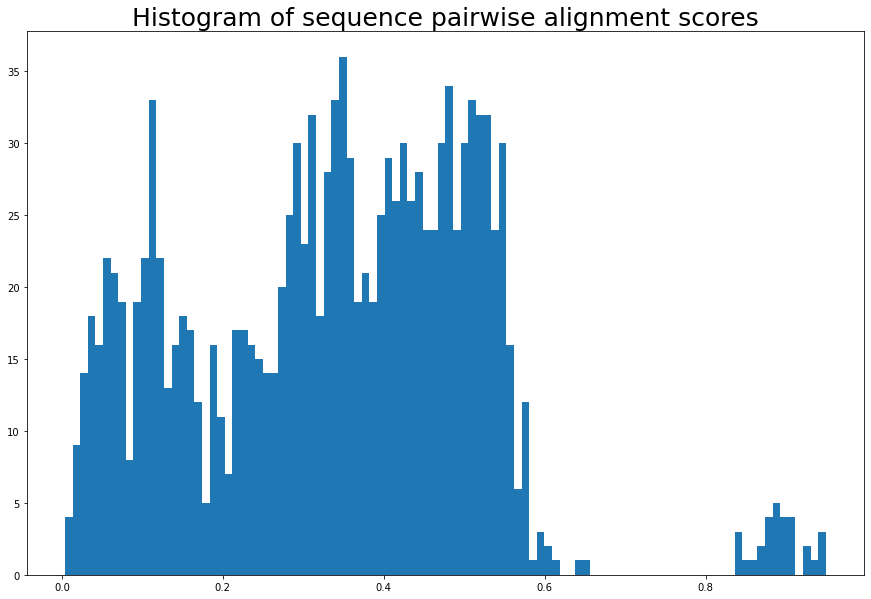

In [135]:
## Visualization of the histogram
plt.figure(figsize=(15,10))
plt.hist(normalized_scores_hist, bins=100)
## displaying the title
plt.title("Histogram of sequence pairwise alignment scores", size=25)
## res = sns.kdeplot(normalized_scores_hist, color='green')
plt.show()

In [34]:
# sort in desc order the normalized score so it is easier to find the threshold
# change the key values from ascending to descending order
desc_normalized_scores = dict(sorted(normalized_scores_hist.items(), key=lambda item: item[0], reverse=True))

# finding the threshold from normalized scores dictionary
threshold_position = 0
threshold_position_by_default = min(len(ch_seq), len(mouse_seq)) # finding the minimal number of transcripts?
threshold = 0

# get the value from our hist_dictionary
for k,v in desc_normalized_scores.items():
    threshold_position += v
    if threshold_position == threshold_position_by_default:
        threshold = k

In [35]:
threshold

0.5909090909090909

In [36]:
import networkx as nx

In [37]:
# Creating a mouse and human NetworkX Graphs
mG = nx.DiGraph() # mouse graph
chG = nx.DiGraph() # human graph

In [38]:
# build the mouse NetworkX nodes
for node in mgene_graph.nodes.values():
    mG.add_nodes_from([
    (node.id, {'start': node.start, 'end': node.end, 'id': node.id,
                             'weight': 1, 'length': (node.end - node.start)})])

# build the human NetworkX nodes
for node in chgene_graph.nodes.values():
    chG.add_nodes_from([
    (node.id, {'start': node.start, 'end': node.end, 'id': node.id,
                             'weight': 1, 'length': (node.end - node.start)})])
    
# build the mouse NetworkX edges
for edge in mgene_graph.edges.values():
    mG.add_edge(edge.start_node_id, edge.end_node_id)
    # adding attribute dictionary which can be used in Networkx edge_subst/del/ins_cost function
    mG.edges[edge.start_node_id, edge.end_node_id].update({"from": edge.start_node_id, "to": edge.end_node_id})

# build the human NetworkX edges
for edge in chgene_graph.edges.values():
    chG.add_edge(edge.start_node_id, edge.end_node_id)  
    chG.edges[edge.start_node_id, edge.end_node_id].update({"from": edge.start_node_id, "to": edge.end_node_id})

In [39]:
mG.number_of_nodes(), chG.number_of_nodes()

(41, 38)

In [40]:
chG.edges

OutEdgeView([(2, 3), (3, 4), (4, 5), (5, 6), (6, 7), (7, 8), (8, 9), (9, 10), (10, 11), (11, 12), (12, 13), (13, 14), (14, 15), (15, 16), (16, 17), (17, 18), (18, 19), (19, 20), (20, 21), (21, 22), (22, 23), (22, 37), (23, 39), (25, 26), (26, 27), (27, 28), (28, 29), (29, 30), (30, 31), (31, 32), (32, 40), (35, 36), (36, 2), (37, 38), (38, 39), (39, 25), (40, 41), (41, 34)])

In [42]:
mG.edges

OutEdgeView([(2, 3), (3, 4), (4, 5), (5, 6), (6, 7), (7, 8), (8, 9), (9, 10), (10, 11), (11, 12), (12, 13), (13, 14), (14, 15), (15, 16), (16, 17), (17, 18), (18, 19), (19, 20), (20, 21), (21, 39), (23, 24), (24, 25), (25, 26), (26, 27), (27, 28), (28, 29), (29, 30), (30, 40), (33, 42), (33, 37), (35, 36), (36, 2), (38, 39), (39, 23), (40, 41), (41, 45), (41, 33), (42, 43), (44, 45), (45, 46), (45, 33)])

# Boolean score matrix

In [70]:
bool_score_matrix = score_matrix
maxValues = bool_score_matrix.max(axis = 1)
bool_score_matrix = bool_score_matrix.eq(bool_score_matrix.where(bool_score_matrix != 0).max(1), axis=0).astype(int)
bool_score_matrix = bool_score_matrix.T

In [71]:
bool_score_matrix

,35,36,2,3,4,5,6,7,8,9,...,26,27,28,29,30,31,32,40,41,34
35,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
36,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,1,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
6,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [45]:
score_matrix_T = score_matrix.copy()
score_matrix_T = score_matrix_T.T    # col represent human node ids

for col in score_matrix_T: 
    max_vals = score_matrix_T[col].nlargest(2)                           # get first two max values from a human column
    result = all(elem == list(max_vals)[0] for elem in list(max_vals))   # check if they are identical
    if result:                                                           # if we have duplicates of max values, we take the longest node
        max_len = {}
        for index, value in max_vals.items():
            for element in mgene_graph.elements:                         # loop through the mgene_splicing_graph
                if element['id'] == index and element['type'] == 'Node': # get the node lengths for comparrison
                    max_len[index]=element['length']
                    
        # take the id with the highest value
        max_key = max(max_len, key=max_len.get)
        print("Have to update human col", col, 'mouse row', max_key)
        
        ## assigning zeros in the columns 
        bool_score_matrix[bool_score_matrix[col] != 0] = 0
        print(col, max_key)
        
        ## assigning 1 to the max vlaue of a column 
        row_index = bool_score_matrix.index.get_loc(max_key) 
        col_index = bool_score_matrix.columns.get_loc(col)
        bool_score_matrix.iat[row_index, col_index] = 1



# EDIT DISTANCE

NODE MATCH

EDGE MATCH

In [46]:
## Transpose again so the graph edit_functions work properly
test_bool_score_matrix = bool_score_matrix.T

In [47]:
test_bool_score_matrix.sum(axis=0) # col sums

35    1
36    0
2     1
3     1
4     1
5     5
6     1
7     1
8     1
9     1
10    1
11    1
12    1
13    1
14    1
15    1
16    1
17    1
18    1
19    1
20    1
21    1
38    0
39    1
23    1
24    1
25    1
26    1
27    1
28    1
29    1
30    1
40    0
41    0
44    0
45    1
46    1
33    1
37    0
42    1
43    0
dtype: int64

In [48]:
test_bool_score_matrix.sum(axis=1) # row sums

35    1
36    1
2     1
3     1
4     1
5     1
6     1
7     1
8     1
9     1
10    1
11    1
12    1
13    1
14    1
15    1
16    1
17    1
18    1
19    1
20    1
21    1
22    1
23    1
37    1
38    1
39    1
25    1
26    1
27    1
28    1
29    1
30    1
31    1
32    1
40    1
41    1
34    1
dtype: int64

In [51]:
##### the neewest and bestest try 23.may meeting

def nmatch(node1, node2):
    """
    check if the nodes are equal by seq alignmet score
    
    """
    match = False
    row_index = score_matrix.index.get_loc(node1['id']) # human, so G1 MUST be the human graph
    col_index = score_matrix.columns.get_loc(node2['id']) # mouse, so G2 MUST be the mouse graph
    seq_align_normalized_score = score_matrix.iat[row_index, col_index] #

    if seq_align_normalized_score >= threshold and test_bool_score_matrix.iat[row_index, col_index] == 1:
        match = True
    return match
    

def ematch(edge1, edge2):
    """
    check if the edges are equal, if yes then apply no cost, else apply 3
    (from: node1, to: node2)
    """
    match = False
    row_index1 = score_matrix.index.get_loc(edge1["from"]) # G1_node1 end coordinate id
    col_index1 = score_matrix.columns.get_loc(edge2["from"])                 # G2_node1 end coordinate id
    start_coordin_seq_align_score = score_matrix.iat[row_index1, col_index1] # seq_align_score for first node
    start_match = start_coordin_seq_align_score >= threshold and test_bool_score_matrix.iat[row_index1, col_index1] == 1
    
    row_index2 = score_matrix.index.get_loc(edge1["to"]) # G1_node2 end coordinate id
    col_index2 = score_matrix.columns.get_loc(edge2["to"]) # G2_node2 end coordinate id
    end_coordin_seq_align_score = score_matrix.iat[row_index2, col_index2] # seq_align_score for second node
    end_match = end_coordin_seq_align_score >= threshold and test_bool_score_matrix.iat[row_index2, col_index2] == 1
    
    if start_match and end_match:
        match = True
    return match
    
    
def node_subst_cost(node1, node2):
    """
    check if the nodes are equal by seq alignmet score
    
    """
    row_index = score_matrix.index.get_loc(node1['id']) # human, so G1 MUST be the human graph
    col_index = score_matrix.columns.get_loc(node2['id']) # mouse, so G2 MUST be the mouse graph
    seq_align_normalized_score = score_matrix.iat[row_index, col_index] #

    if seq_align_normalized_score > threshold and test_bool_score_matrix.iat[row_index, col_index] == 1:
#         print("Node ids that match", row_index, col_index)
        return 0
    else:
        node_subst_cost_ = 1 - seq_align_normalized_score
        return node_subst_cost_
    
    
def node_del_cost(node):
    return threshold/2  # here you apply the cost for node deletion

def node_ins_cost(node):
    return threshold/2  # here you apply the cost for node insertion


def edge_subst_cost(edge1, edge2):
    """
    check if the edges are equal, if yes then apply no cost, else apply 3
    (from: node1, to: node2)
    """
    row_index1 = score_matrix.index.get_loc(edge1["from"]) # G1_node1 end coordinate id
    col_index1 = score_matrix.columns.get_loc(edge2["from"]) # G2_node1 end coordinate id
    start_coordin_seq_align_score = score_matrix.iat[row_index1, col_index1] # seq_align_score for first node
    
    row_index2 = score_matrix.index.get_loc(edge1["to"]) # G1_node2 end coordinate id
    col_index2 = score_matrix.columns.get_loc(edge2["to"]) # G2_node2 end coordinate id
    end_coordin_seq_align_score = score_matrix.iat[row_index2, col_index2] # seq_align_score for second node
    
    if start_coordin_seq_align_score > threshold and end_coordin_seq_align_score > threshold:
#         print("Edge match ids:" ,edge1, edge2)
        return 0
    else:
        egde_subst_cost_ = 1 - sum([start_coordin_seq_align_score,end_coordin_seq_align_score])/2
        return egde_subst_cost_

def edge_del_cost(node):
    return threshold  # here you apply the cost for edge deletion

def edge_ins_cost(node):
    return threshold  # here you apply the cost for edge insertion


graph_edit_paths = []

# optimal_edit_paths
for node_edit_path, edge_edit_path, cost in nx.optimize_edit_paths(chG, mG, timeout = 20,
    node_match=nmatch,
    node_del_cost=node_del_cost,
    node_ins_cost=node_ins_cost,                                          
    edge_match=ematch,
    edge_del_cost=edge_del_cost,
    edge_ins_cost=edge_ins_cost                                   
):
    graph_edit_paths.append([node_edit_path, edge_edit_path, cost])

In [52]:
cost

16.250000000000004

In [73]:
edge_edit_path

[((2, 3), (2, 3)),
 ((3, 4), (3, 4)),
 ((4, 5), (4, 5)),
 ((5, 6), (5, 6)),
 ((6, 7), (6, 7)),
 ((7, 8), (7, 8)),
 ((8, 9), (8, 9)),
 ((9, 10), (9, 10)),
 ((10, 11), (10, 11)),
 ((11, 12), (11, 12)),
 ((12, 13), (12, 13)),
 ((13, 14), (13, 14)),
 ((14, 15), (14, 15)),
 ((15, 16), (15, 16)),
 ((16, 17), (16, 17)),
 ((17, 18), (17, 18)),
 ((18, 19), (18, 19)),
 ((19, 20), (19, 20)),
 ((20, 21), (20, 21)),
 ((21, 22), (21, 39)),
 ((22, 23), (39, 23)),
 ((25, 26), (25, 26)),
 ((26, 27), (26, 27)),
 ((27, 28), (27, 28)),
 ((28, 29), (28, 29)),
 ((29, 30), (29, 30)),
 ((30, 31), None),
 ((31, 32), None),
 ((35, 36), None),
 ((36, 2), None),
 ((22, 37), None),
 ((37, 38), None),
 ((23, 39), (23, 24)),
 ((38, 39), None),
 ((39, 25), (24, 25)),
 ((32, 40), None),
 ((40, 41), None),
 ((41, 34), (33, 42)),
 (None, (45, 33)),
 (None, (35, 36)),
 (None, (36, 2)),
 (None, (33, 37)),
 (None, (38, 39)),
 (None, (30, 40)),
 (None, (40, 41)),
 (None, (41, 45)),
 (None, (41, 33)),
 (None, (42, 43)),
 (No

# Node coloring

In [ ]:
from distinctipy import distinctipy

# Node coloring

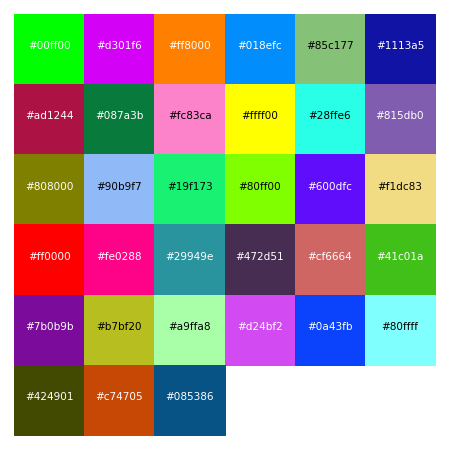

In [110]:
# only color nodes that were matched
node_edit_path_matches = [e for e in node_edit_path if e[0] is not None and e[1] is not None]

# number of colours to generate
N = len(node_edit_path_matches)

# generate N visually distinct colours
colors = distinctipy.get_colors(N)

colored_node_edit_path = []

# assign random color to the edited nodes
colored_node_edit_path = list(zip(node_edit_path_matches, colors))
colored_node_edit_path

# display the colours
distinctipy.color_swatch(colors, show_text=True)


# Chimpanze

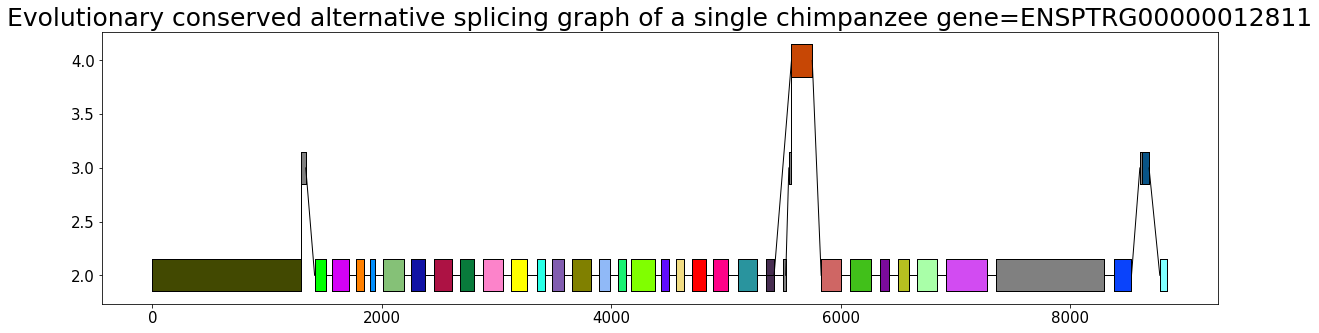

In [163]:
## canvas https://matplotlib.org/3.5.0/api/_as_gen/matplotlib.lines.Line2D.html#matplotlib.lines.Line2D.set_linewidth

figure, canvas = plt.subplots(figsize=(20,5))
canvas.set_facecolor('white') # background color # ---USER INPUT--- #
canvas.set_title('Evolutionary conserved alternative splicing graph of a single chimpanzee gene=ENSPTRG00000012811', size=25)

node_start_y = {}
node_end_y = {}
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

levels = []

for element in chgene_graph.elements:
    # append level number to an array
    levels.append(element['y']) if element['y'] not in levels else levels
    
    if element['type'] == 'Node':
        node_start_y[element['start']] = element['y'] # ???
        node_end_y[element['end']] = element['y'] # ???
        
        # Node colloring
        have_color = False
        for i in colored_node_edit_path:
            if element['id'] == i[0][0]:
                draw_node_color = i[1]
                have_color = True
            if not have_color:
                draw_node_color = (128/255, 128/255, 128/255) # grey

            for edge in chgene_graph.edges.values():
                start = chgene_graph.nodes[edge.start_node_id].end
                end = chgene_graph.nodes[edge.end_node_id].start
                if start == element['start'] and end == element['end']:
                    retained_intron_color = 'orange'
                    
            # padotas taisnstūra koordinātes, kas ir jāaizkrāso. y=līmenis, tāpēc taisnstūra augstums ir +-0,25 no y
            canvas.fill_between([element['x'], element['x']+element['length']], element['y']-0.15, element['y']+0.15, edgecolor='black', facecolor=draw_node_color)
    levels.sort()

for element in chgene_graph.elements:
    if element['type'] == 'Edge':
        edge = chgene_graph.edges[element['id']]
        for element2 in chgene_graph.elements:
            if element2['type'] == "Node":
                if element2['id'] == edge.start_node_id:
                    element['x1'] = element2['x'] + element2['length']
                if element2['id'] == edge.end_node_id:
                    element['x2'] = element2['x']
        if element['id'] == 9999999: # ???
            canvas.plot([element['x1'], element['x2']], [node_end_y[element['start']], node_start_y[element['end']]], color='yellow', linewidth=element['weight'], ls='-', )
        else:
            canvas.plot([element['x1'],element['x2']], [node_end_y[element['start']], node_start_y[element['end']]], color='black', linewidth=element['weight'], ls='-', )

# Mouse

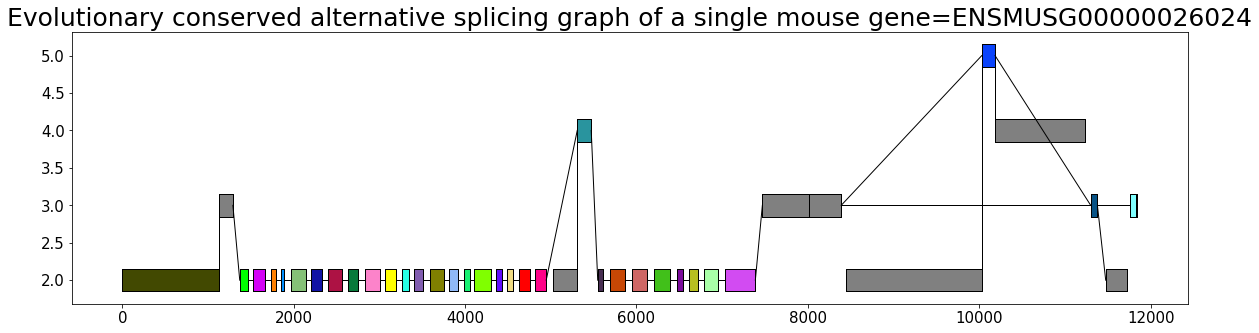

In [159]:
## canvas https://matplotlib.org/3.5.0/api/_as_gen/matplotlib.lines.Line2D.html#matplotlib.lines.Line2D.set_linewidth

figure, canvas = plt.subplots(figsize=(20,5))
canvas.set_facecolor('white') # background color # ---USER INPUT--- #
canvas.set_title('Evolutionary conserved alternative splicing graph of a single mouse gene=ENSMUSG00000026024', size=25)
# canvas.invert_xaxis()
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

node_start_y = {}
node_end_y = {}

levels = []


for element in mgene_graph.elements:
    # append level number to an array
    levels.append(element['y']) if element['y'] not in levels else levels
    
    if element['type'] == 'Node':
        node_start_y[element['start']] = element['y'] # ???
        node_end_y[element['end']] = element['y'] # ???
        

        # Node coloring
        have_color = False
        for i in colored_node_edit_path:
            if element['id'] == i[0][1]:
                draw_node_color = i[1]
                have_color = True
            if not have_color:
                draw_node_color = (128/255, 128/255, 128/255) # grey

            for edge in mgene_graph.edges.values():
                start = mgene_graph.nodes[edge.start_node_id].end
                end = mgene_graph.nodes[edge.end_node_id].start
                if start == element['start'] and end == element['end']:
                    retained_intron_color = 'orange'
                    
            # padotas taisnstūra koordinātes, kas ir jāaizkrāso. y=līmenis, tāpēc taisnstūra augstums ir +-0,25 no y
            canvas.fill_between([element['x'], element['x']+element['length']], element['y']-0.15, element['y']+0.15, edgecolor='black', facecolor=draw_node_color)
    levels.sort()

for element in mgene_graph.elements:
    if element['type'] == 'Edge':
        edge = mgene_graph.edges[element['id']]
        for element2 in mgene_graph.elements:
            
            if element2['type'] == "Node":
                if element2['id'] == edge.start_node_id:
                    element['x1'] = element2['x'] + element2['length']
                if element2['id'] == edge.end_node_id:
                    element['x2'] = element2['x']
        if element['id'] == 9999999: # ???
            canvas.plot([element['x1'], element['x2']], [node_end_y[element['start']], node_start_y[element['end']]], color='yellow', linewidth=element['weight'], ls='-', )
        else:
            canvas.plot([element['x1'],element['x2']], [node_end_y[element['start']], node_start_y[element['end']]], color='black', linewidth=element['weight'], ls='-', )
            
            
 
plt.savefig("output_mouse.jpg") #save as jpg
plt.savefig("output_mouse.png") #save as png            